# CS109b Final Project: 
# Air Pollution Exposure and COVID-19 Mortality in the U.S.

## Import libraries

In [84]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## Load and clean data

In [85]:
data = pd.read_csv("./../PM_COVID-master/processed_data_05-03-2020.csv")

In [86]:
#load data
#data = pd.read_csv('https://raw.githubusercontent.com/CS109b-Team37/Pollution-Prediction/master/PM_COVID-master/processed_data_04-24-2020.csv')

In [87]:
#rename older_pecent to older_percent
data = data.rename(columns={'older_pecent': 'older_percent'})

#drop columns
cols = list(data.columns)
cols.remove('Unnamed: 0') #just a column of integers 1-21560
#cols.remove('Province_State') #redundant information; already captured by 'state'
cols.remove('Country_Region') #only US
cols.remove('Combined_Key') #redundant information; already captured by 'Province_State' and 'Admin2'
cols.remove('year.x') #only 2016
cols.remove('year.y') #only 2012 and nan
cols.remove('Population') #'older_pecent' was calculated by Population/older_Population
cols.remove('older_Population') #'older_pecent' was calculated by Population/older_Population
cols.remove('date') #only 20200502
cols.remove('hash') #useless information
cols.remove('dateChecked') #only '2020-05-02T20:00:00Z'
cols.remove('Abbrev') #redundant information; already captured by 'state'
cols.remove('total') #almost a repeat of 'totalTestResults'
cols.remove('Recovered') #only 0
data = data[cols]


In [88]:
data['Last_Update'].unique()

array(['2020-05-04 02:32:28', '3/30/20 22:52'], dtype=object)

In [89]:
#convert Last_Update to binary variable
convert_dict = {'2020-05-04 02:32:28': 0, '3/30/20 22:52': 1}
data = data.replace({'Last_Update': convert_dict})


In [90]:
#variables with NA values
print('Variables with NA values:')
display(data.isna().sum()[data.isna().sum() > 0])

#remove variables with many NA values
na_vars = list(data.isna().sum()[data.isna().sum() > 50].index) #variables with many NA values
data = data[set(cols) - set(na_vars)] #final cleaned data

Variables with NA values:


smoke_rate                 867
mean_bmi                   867
Crude.Rate                   1
older_percent                1
pending                   2798
hospitalizedCurrently      719
hospitalizedCumulative    1276
inIcuCurrently            1783
inIcuCumulative           2345
onVentilatorCurrently     1953
onVentilatorCumulative    2839
recovered                 1074
hospitalized              1276
beds                       811
dtype: int64

In [91]:
#both NA values are for Loving, Texas
null_data = data[data.isnull().any(axis=1)]
print('Rows with NA values:')
display(null_data)

#fill in NA values for 'Crude.Rate' and 'older_percent' with state average
values = {'Crude.Rate': data.groupby('state').mean()['Crude.Rate']['TX'], 'older_percent': data.groupby('state').mean()['older_percent']['TX']}
data = data.fillna(value=values)

Rows with NA values:


,medianhousevalue,deathIncrease,mean_pm25,Province_State,q_popdensity,Deaths,Crude.Rate,older_percent,state,Last_Update,Lat,fips,mean_summer_temp,pct_owner_occ,pct_asian,population,pct_native,popdensity,positive,Confirmed,pct_blk,pct_white,negative,poverty,hispanic,hospitalizedIncrease,mean_winter_temp,mean_summer_rm,positiveIncrease,totalTestResultsIncrease,totalTestResults,mean_winter_rm,Long_,education,posNeg,population_frac_county,Admin2,medhouseholdincome,negativeIncrease,totalTestResults_county,Active,death
2635,89040.0,20,5.685412,Texas,1,0,NaN,NaN,TX,1,31.849476,48301,309.483185,0.485714,0.0,63,0.047619,0.395035,31548,0,0.0,0.857143,359012,0.631579,0.142857,0,290.213523,73.844694,1026,9912,390560,72.837808,-103.581857,0.526316,390560,0.000002,Loving,55625.0,8886,0.91409,0,867


## Modeling

In [412]:
#remove posNeg, since it is the same as totalTestResults
cols = list(data.columns)
cols.remove('posNeg') 
cols.remove('Deaths') #remove deaths because we are trying to predict cases
cols.remove('death')
cols.remove('fips')
cols.remove('state') #redundant, given Province_State
cols.remove('Admin2') #county names
dataTH = data[cols]


In [413]:
#load tests data
#directly from https://www.vox.com/2020/3/26/21193848/coronavirus-us-cases-deaths-tests-by-state (5/5/2020)
#which got the data from COVID Tracking Project, Census Bureau
tests_data = pd.read_csv("./../tests_data.csv")


In [414]:
#subset data to only include the 49 states in our dataset
states_in_data = dataTH['Province_State'].unique()
tests_data_sub = tests_data.loc[tests_data['state'].isin(states_in_data)]

#remove DC from the dataset because our data only has one observation for DC
tests_data_sub = tests_data_sub[tests_data_sub['state'] != 'District of Columbia']

#examine dataset
tests_data_sub.sort_values(by='tests_per_thousand_people', ascending=False)

,state,confirmed_cases,deaths,tests_conducted,tests_per_million_people,tests_per_thousand_people
55,Rhode Island,9477,320,71927,67897,67.897
54,New York,316415,19189,985911,50680,50.680
53,Massachusetts,68087,4004,314646,45650,45.650
52,North Dakota,1191,25,33353,43767,43.767
51,Utah,5175,50,122102,38086,38.086
50,Louisiana,29340,1969,176160,37894,37.894
49,New Mexico,3732,139,74944,35742,35.742
47,New Jersey,126744,7871,275707,31040,31.040
46,Tennessee,13177,210,204607,29961,29.961
44,West Virginia,1191,50,51638,28813,28.813


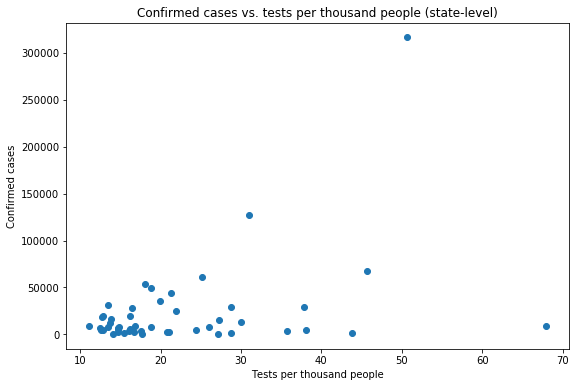

In [415]:
#states that conduct more testing have more confirmed cases
fig, ax = plt.subplots(1, 1, figsize = (9, 6))
ax.scatter(tests_data_sub['tests_per_thousand_people'], tests_data_sub['confirmed_cases'])
ax.set_title('Confirmed cases vs. tests per thousand people (state-level)')
ax.set_xlabel('Tests per thousand people')
ax.set_ylabel('Confirmed cases');

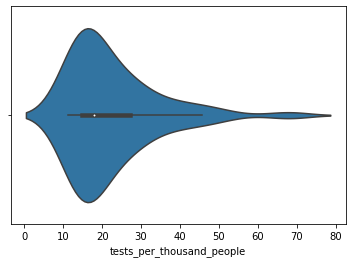

In [416]:
#plot distribution of tests_per_thousand_people; find cutoff

#ax = sns.distplot(tests_data_sub['tests_per_thousand_people']) #histogram
#ax = sns.boxplot(x=tests_data_sub['tests_per_thousand_people']) #boxplot
ax = sns.violinplot(x=tests_data_sub['tests_per_thousand_people']) #violinplot

In [417]:
np.median(tests_data_sub['tests_per_thousand_people'])
np.quantile(tests_data_sub['tests_per_thousand_people'], 0.25)

14.68575

In [419]:
#divide states into heavy states that have 

#threshold = np.median(tests_data_sub['tests_per_thousand_people'])
threshold = np.quantile(tests_data_sub['tests_per_thousand_people'], 0.25)
states_high = tests_data_sub[tests_data_sub['tests_per_thousand_people'] >= threshold].state.values
states_low = tests_data_sub[tests_data_sub['tests_per_thousand_people'] < threshold].state.values

#split data based on these two groups
states_high_data = dataTH.loc[dataTH['Province_State'].isin(states_high)]
states_low_data = dataTH.loc[dataTH['Province_State'].isin(states_low)]

print('Number of states with high levels of testing', len(states_high))
print('Number of states with high levels of testing', len(states_low))

Number of states with high levels of testing 36
Number of states with high levels of testing 12


In [420]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [421]:
#train model on states_high_data
X = states_high_data.loc[:, states_high_data.columns != 'Confirmed']
X = pd.get_dummies(X, columns = ['Province_State'], prefix = 'state') #one-hot encode states
y = states_high_data['Confirmed']

#split states_high_data into train and test sets
states_cols = list(X.columns[-36:-1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify = X[states_cols])

In [424]:
#set parameters
n_units = 20
drop_rate = 0.1
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
loss = 'mse'
#metrics = ['accuracy']


#define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(n_units, activation = 'relu', input_shape = (70,)))
#model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_units/4, activation='relu'))
#model.add(tf.keras.layers.Dropout(drop_rate))
#model.add(tf.keras.layers.Dense(n_units/2, activation='relu'))
#model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(1, activation='relu'))

# Compile model
model.compile(optimizer=optimizer, loss=loss)
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 20)                1420      
_________________________________________________________________
dense_102 (Dense)            (None, 5)                 105       
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 6         
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0
_________________________________________________________________


In [425]:
batch_size = 16
epochs = 30
validation_split = 0.1
verbose = 1

history = model.fit(np.asarray(X_train), np.asarray(y_train), epochs=epochs, batch_size=batch_size, validation_split=validation_split, 
                    verbose=verbose)


Train on 1553 samples, validate on 173 samples
Epoch 1/30
1553/1553 [==============================] - 1s 688us/sample - loss: 306535793.3623 - val_loss: 30912352.7554
Epoch 2/30
1553/1553 [==============================] - 0s 213us/sample - loss: 89817062.1223 - val_loss: 10107077.4942
Epoch 3/30
1553/1553 [==============================] - 0s 154us/sample - loss: 44003451.9549 - val_loss: 6846327.5694
Epoch 4/30
1553/1553 [==============================] - 0s 158us/sample - loss: 32312882.6336 - val_loss: 6078976.8179
Epoch 5/30
1553/1553 [==============================] - 0s 154us/sample - loss: 28117384.5489 - val_loss: 5942964.2399
Epoch 6/30
1553/1553 [==============================] - 0s 178us/sample - loss: 26091964.9968 - val_loss: 5937864.5867
Epoch 7/30
1553/1553 [==============================] - 0s 164us/sample - loss: 25688810.1524 - val_loss: 5937864.5867
Epoch 8/30
1553/1553 [==============================] - 0s 189us/sample - loss: 25526252.0696 - val_loss: 5937864.586

In [377]:
#save model
#model.save('saved_models/model')

#load model
model = tf.keras.models.load_model('saved_models/model')

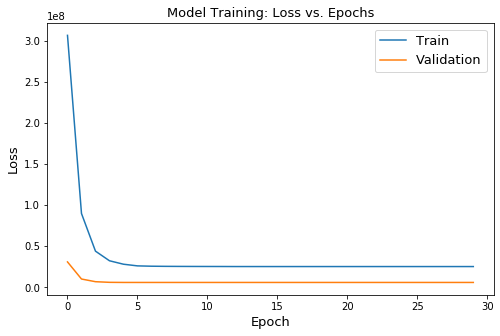

In [426]:
#plot acccruacies

def plot_loss_vs_epoch(history, title):
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    ax.plot(history['loss'], label = 'Train')
    ax.plot(history['val_loss'], label = 'Validation')
    ax.set_xlabel('Epoch', size = 13)
    ax.set_ylabel('Loss', size = 13)
    ax.set_title(title, size = 13)
    ax.legend(fontsize = 13)
    
#plot loss vs. epochs
plot_loss_vs_epoch(history.history, 'Model Training: Loss vs. Epochs')

In [427]:
#model predictions

#predict states_high training set
pred_stateshigh_train = model.predict(np.asarray(X_train))


In [432]:
X_train

,medianhousevalue,deathIncrease,mean_pm25,q_popdensity,Crude.Rate,older_percent,Last_Update,Lat,mean_summer_temp,pct_owner_occ,pct_asian,population,pct_native,popdensity,positive,pct_blk,pct_white,negative,poverty,hispanic,hospitalizedIncrease,mean_winter_temp,mean_summer_rm,positiveIncrease,totalTestResultsIncrease,totalTestResults,mean_winter_rm,Long_,education,population_frac_county,medhouseholdincome,negativeIncrease,totalTestResults_county,Active,state_Alabama,state_Arkansas,state_California,state_Connecticut,state_Delaware,state_Florida,state_Georgia,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Mississippi,state_Nebraska,state_Nevada,state_New Hampshire,state_New Jersey,state_New Mexico,state_New York,state_North Dakota,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode Island,state_South Dakota,state_Tennessee,state_Utah,state_Vermont,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
1158,123561.538462,30,10.858380,3,1232.6,0.181643,0,39.623576,301.255024,0.770668,0.004186,71329,0.000528,215.162232,25462,0.024565,0.959648,107332,0.064516,0.014254,141,277.475345,91.034726,989,7272,132794,85.105435,-78.692805,0.224549,0.012014,41491.538462,6283,1595.403145,112,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1679,88600.000000,3,5.806299,1,1063.6,0.182617,0,41.166243,303.402894,0.793457,0.000440,7462,0.001434,10.896816,5326,0.004315,0.970735,25936,0.082184,0.029762,0,276.554541,88.533865,488,1914,31262,89.078683,-98.037489,0.072354,0.003973,51937.000000,1426,124.194318,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1180,198735.555556,30,11.203298,3,1152.9,0.227337,0,38.212743,302.621190,0.670879,0.007083,51720,0.000717,202.091960,25462,0.134156,0.844974,107332,0.073314,0.026494,141,281.869862,95.933821,989,7272,132794,85.441323,-75.332000,0.307875,0.008711,57974.833333,6283,1156.812105,72,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2753,143586.030769,1,5.197528,1,1102.0,0.215170,1,38.338153,298.915768,0.943436,0.000000,1721,0.000427,14.336964,5175,0.000000,0.997850,116927,0.101535,0.025071,18,277.068495,53.751790,194,4298,122102,80.301183,-112.124959,0.196480,0.000691,33345.257143,4104,84.334975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3045,104285.714286,5,6.310992,1,1198.3,0.198721,0,45.474989,298.819312,0.813062,0.001666,12367,0.005728,14.579017,7964,0.011821,0.965155,77997,0.114702,0.014470,17,269.393419,92.997566,304,2731,85961,93.352423,-91.133301,0.189757,0.002156,41153.428571,2427,185.289837,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2340,63524.875000,0,3.900010,1,1009.0,0.110185,0,45.708900,301.947398,0.575951,0.003455,3960,0.479802,4.073356,2631,0.000948,0.501828,15786,0.292860,0.002302,10,271.624597,88.054544,43,326,18417,91.601854,-101.197047,0.245315,0.004744,33534.125000,283,87.375232,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
444,84300.000000,3,11.091485,2,1073.5,0.144783,0,32.463252,306.746894,0.715324,0.003727,47268,0.001191,44.674965,28602,0.251550,0.720017,146494,0.160581,0.017541,6,289.206655,96.852229,296,296,175096,87.196013,-82.922213,0.251377,0.004696,35759.875000,0,822.165683,63,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1997,106250.000000,1,3.391403,1,557.9,0.189899,0,46.447377,300.926725,0.816010,0.000000,306,0.000000,0.573338,1191,0.087432,0.901639,32162,0.152632,0.005464,0,272.315212,87.612977,38,1806,33353,93.382910,-103.460155,0.308187,0.000423,50937.500000,1768,14.118961,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [398]:
pd.DataFrame(y_train)

,Confirmed
1158,124
1679,19
1180,75
2753,0
3045,4
...,...
2340,1
444,64
1997,3
1753,6871


In [ ]:

#predict states_high test set
pred_stateshigh_test

#predict states_low
pred_stateslow

In [154]:
#test model on states_low_data



In [ ]:
#check that states_high and states_low have similar distributions
#check model performance with and without pm2.5 levels